In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
plt.style.use('seaborn')

filepath = os.path.join("raw_data", "team_game_level_data.csv")
team_game_df = pd.read_csv(filepath)

split_date = team_game_df["date"].str.split("-")
count = 0
for row in split_date:
    team_game_df.at[count,'year'] = row[0]
    count += 1
team_game_df

# remove play-in games
no_play_ins = team_game_df.loc[team_game_df["round"] != "Opening Round", :]
no_play_ins.head()

,game_id,date,round,region,seed,team,score,opponent_seed,opponent,opponent_score,overtime,score_diff,win,seed_id,year
0,0,1985-03-14,Round of 64,East,1,Georgetown,68,16,Lehigh,43,NaN,25,1,1_16_fav,1985
1,0,1985-03-14,Round of 64,East,16,Lehigh,43,1,Georgetown,68,NaN,-25,0,1_16_dog,1985
2,1,1985-03-14,Round of 64,East,4,"Loyola, Illinois",59,13,Iona,58,NaN,1,1,4_13_fav,1985
3,1,1985-03-14,Round of 64,East,13,Iona,58,4,"Loyola, Illinois",59,NaN,-1,0,4_13_dog,1985
4,2,1985-03-14,Round of 64,East,5,Southern Methodist,85,12,Old Dominion,68,NaN,17,1,5_12_fav,1985


In [2]:
# filter data by seed and store
seed_count = 128
avg_wins_by_seed = []
avg_pt_spread_by_seed = []
wins_by_round_by_seed = []

def get_avg_wins(seed):
    games = no_play_ins.loc[no_play_ins["seed"] == seed, :]
    wins = games["win"].sum()
    avg_wins = wins/seed_count
    return avg_wins

def get_avg_pt_spread(seed):
    games = no_play_ins.loc[no_play_ins["seed"] == seed, :]
    avg_pt_spread = games["score_diff"].mean()
    return avg_pt_spread

def get_round_by_round(seed):
    games = no_play_ins.loc[no_play_ins["seed"] == seed, :]
    games_by_round = games.groupby("round")
    wins_by_round = games_by_round["win"].sum()
    return wins_by_round

for seed in range(1,17):
    avg_wins = get_avg_wins(seed)
    avg_wins_by_seed.append(avg_wins)
    avg_pt_spread = get_avg_pt_spread(seed)
    avg_pt_spread_by_seed.append(avg_pt_spread)
    wins_by_round = get_round_by_round(seed)
    wins_by_round_by_seed.append(wins_by_round)

seed_summaries = pd.DataFrame({
    "Seed":range(1,17),
    "Average Wins":avg_wins_by_seed,
    "Average Point Spread": avg_pt_spread_by_seed,
    "Wins by Round": wins_by_round_by_seed
})

seed_summaries = seed_summaries.set_index("Seed")
save_path = os.path.join("raw_data", "seed_summaries.csv")
seed_summaries.to_csv(save_path)
seed_summaries

,Average Point Spread,Average Wins,Wins by Round
Seed,,,
1,11.392193,3.351562,round Elite Eight 52 National Ch...
2,7.109302,2.398438,round Elite Eight 28 National Ch...
3,4.960452,1.796875,round Elite Eight 14 National Ch...
4,3.313846,1.546875,round Elite Eight 13 National Ch...
5,0.892593,1.109375,round Elite Eight 6 National Cha...
6,0.335793,1.125000,round Elite Eight 3 National Cha...
7,-0.585062,0.890625,round Elite Eight 2 National Cha...
8,-3.281818,0.726562,round Elite Eight 5 National Cha...
9,-4.220000,0.562500,round Elite Eight 1 National Semif...


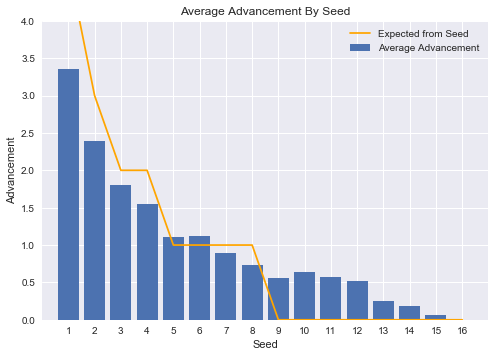

In [3]:
# plot average wins by seed
plt.bar(seed_summaries.index, seed_summaries["Average Wins"])
tick_locations = seed_summaries.index
plt.title("Average Advancement By Seed")
plt.ylabel("Advancement")
plt.xlabel("Seed")
plt.xticks(tick_locations, seed_summaries.index)
#####################################################################################################
# yticks = ["Round of 64","Round of 32","Sweet Sixteen","Elite Eight","Final Four"]
# plt.yticks(range(5),yticks)
#####################################################################################################
plt.ylim(0,4)
plt.xlim(0,17)

seed_expectations = [4.75,3,2,2,1,1,1,1,0,0,0,0,0,0,0,0]
plt.plot(tick_locations, seed_expectations, c="orange")

plt.legend(["Expected from Seed","Average Advancement"])
plt.show()

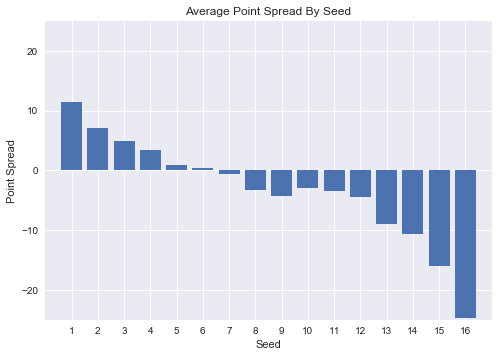

In [4]:
# average point spread by seed
plt.bar(seed_summaries.index, seed_summaries["Average Point Spread"])
tick_locations = seed_summaries.index
plt.title("Average Point Spread By Seed")
plt.ylabel("Point Spread")
plt.xlabel("Seed")
plt.xticks(tick_locations, seed_summaries.index)
plt.ylim(-25,25)
plt.xlim(0,17)
plt.show()

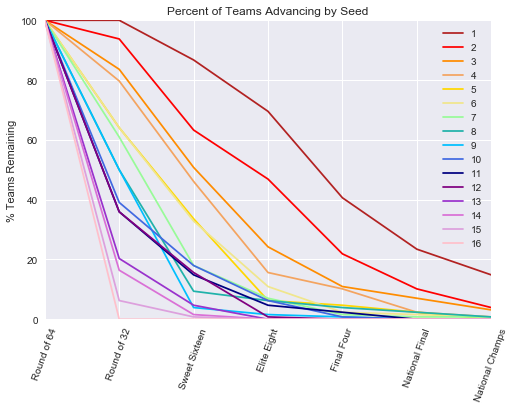

In [5]:
# plot teams remaining by round for each seed
teams_remaining_by_seed = []

def get_wins_in_round(seed_data,tourney_round,seed_count):
    try:
        round_win_pct = (seed_data[tourney_round]/seed_count)*100
    except KeyError:
        round_win_pct = 0
    return round_win_pct

rounds = ["Round of 64","Round of 32", "Sweet Sixteen", "Elite Eight", "National Semifinals", "National Championship"]

for seed in seed_summaries["Wins by Round"]:
    teams_remaining = []
    teams_remaining.append(100)
    for tourney_round in rounds:
        round_win_pct = get_wins_in_round(seed,tourney_round,seed_count)
        teams_remaining.append(round_win_pct)
    teams_remaining_by_seed.append(teams_remaining)
    
colors = ["firebrick","red","darkorange","sandybrown","gold","khaki","palegreen","lightseagreen","deepskyblue","royalblue",
         "navy","purple","darkorchid","orchid","plum","pink"]
    
for i in range(len(teams_remaining_by_seed)):
    plt.plot(teams_remaining_by_seed[i], c=colors[i])
    
xticks = ["Round of 64","Round of 32","Sweet Sixteen","Elite Eight","Final Four","National Final","National Champs"]
tick_locations = range(len(xticks))
plt.title("Percent of Teams Advancing by Seed")
plt.ylabel("% Teams Remaining")
plt.xticks(tick_locations, xticks, rotation=70)
plt.ylim(0,100)
plt.xlim(0,6)
plt.legend(range(1,17))
plt.show()

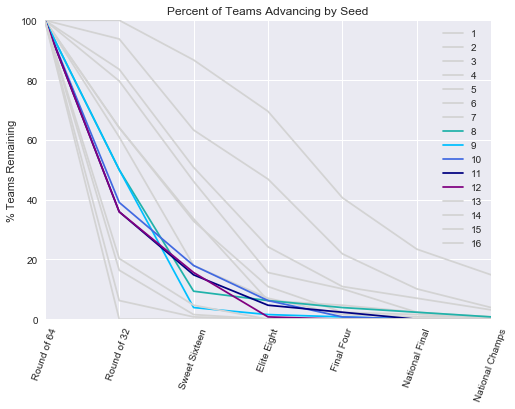

In [6]:
# highlight interesting seeds
    
colors = ["lightgray","lightgray","lightgray","lightgray","lightgray","lightgray","lightgray","lightseagreen",
          "deepskyblue","royalblue","navy","purple","lightgray","lightgray","lightgray","lightgray"]

for i in range(len(teams_remaining_by_seed)):
    plt.plot(teams_remaining_by_seed[i], c=colors[i])

xticks = ["Round of 64","Round of 32","Sweet Sixteen","Elite Eight","Final Four","National Final","National Champs"]
tick_locations = range(len(xticks))
plt.title("Percent of Teams Advancing by Seed")
plt.ylabel("% Teams Remaining")
plt.xticks(tick_locations, xticks, rotation=70)
plt.ylim(0,100)
plt.xlim(0,6)
plt.legend(range(1,17))
plt.show()

In [7]:
# statistical comparison of seeds
score_margins_by_seed = []

for seed in range(1,17):
    games = no_play_ins.loc[(no_play_ins["seed"] == seed)]
    score_margins = games["score_diff"]
    score_margins_by_seed.append(score_margins)

comparisons = []
pvals = []
stat_significant = []
higher_seeds = []
lower_seeds = []
    
for i in range(1,16):
    (statistic, pval) = stats.ttest_ind(score_margins_by_seed[i-1], score_margins_by_seed[i], equal_var=False)
    pvals.append(pval)
    comparison = f"{i} Seed v. {i+1} Seed"
    comparisons.append(comparison)
    if pval < 0.05:
        significant = True
    else:
        significant = False
    stat_significant.append(significant)
    higher_seed = score_margins_by_seed[i-1].mean()
    higher_seeds.append(higher_seed)
    lower_seed = score_margins_by_seed[i].mean()
    lower_seeds.append(lower_seed)
    

seed_comparisons = pd.DataFrame({
    "Seeds":comparisons,
    "P Value":pvals,
    "Statistically Significant":stat_significant,
    "Higher Seed Avg Score Margin":higher_seeds,
    "Lower Seed Avg Score Margin":lower_seeds
})

seed_comparisons

,Higher Seed Avg Score Margin,Lower Seed Avg Score Margin,P Value,Seeds,Statistically Significant
0,11.392193,7.109302,1.159112e-06,1 Seed v. 2 Seed,True
1,7.109302,4.960452,2.164111e-02,2 Seed v. 3 Seed,True
2,4.960452,3.313846,9.320409e-02,3 Seed v. 4 Seed,False
3,3.313846,0.892593,1.742332e-02,4 Seed v. 5 Seed,True
4,0.892593,0.335793,5.877796e-01,5 Seed v. 6 Seed,False
5,0.335793,-0.585062,3.765998e-01,6 Seed v. 7 Seed,False
6,-0.585062,-3.281818,1.387471e-02,7 Seed v. 8 Seed,True
7,-3.281818,-4.220000,4.272341e-01,8 Seed v. 9 Seed,False
8,-4.220000,-3.028571,3.131260e-01,9 Seed v. 10 Seed,False
9,-3.028571,-3.524752,6.685562e-01,10 Seed v. 11 Seed,False


In [8]:
## Creates a function to group and compare data upset data in a bar graph
def upset_bar_chart(team_game_df, column):
    winner_df = team_game_df[team_game_df['win'] == 1].copy()
    winner_df = winner_df[winner_df['seed'] != winner_df['opponent_seed']]
    winner_df['seed_diff'] = winner_df['opponent_seed'] - winner_df['seed']
    winner_df['abs_seed_diff'] = abs(winner_df['seed_diff'])
    winner_df['upset'] = [1 if seed_id[len(seed_id)-3:] == 'dog' else 0 for seed_id in winner_df['seed_id']]
    winner_df['matchup'] = [seed_id if len(seed_id)<6 else seed_id[:len(seed_id)-4] for seed_id in winner_df['seed_id']]
    upsets_groupby = winner_df[['game_id', 'upset', column]].groupby(column)
    upsets_df = upsets_groupby.agg({'game_id': 'count',
                                   'upset': 'sum'})
    upsets_df.columns = ['total_games', 'num_upsets']
    upsets_df.reset_index(inplace=True)
    if column =='round':
        round_num_dict = {'Opening Round': 0,
                          'Round of 64': 1,
                          'Round of 32': 2,
                          'Sweet Sixteen': 3,
                          'Elite Eight': 4,
                          'National Semifinals': 5,
                          'National Championship': 6}
        upsets_df['round_num'] = [round_num_dict[round] for round in upsets_df['round']]
        column = 'round_num'
    upsets_df.sort_values(column, inplace=True)
    upsets_df['upset_perc'] = upsets_df['num_upsets'] / upsets_df['total_games']
    plt.style.use('seaborn')
    tick_loc = range(len(upsets_df[column]))
    plt.figure(figsize=(15,5))
    plt.bar(tick_loc, upsets_df['upset_perc'],
            width=0.2,align='center')
    plt.xticks(tick_loc, upsets_df[column], rotation=90)
    plt.show()
    ##return winner_df

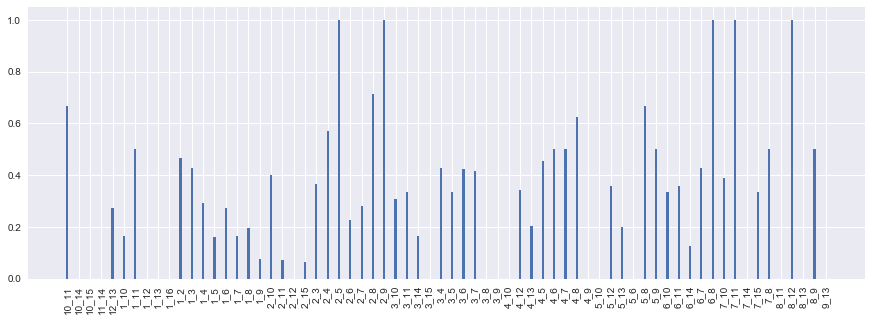

In [9]:
## Shows percentage of upsets by seed matchup

############################################################
# add labels and stuff
############################################################

upset_bar_chart(no_play_ins, 'matchup')

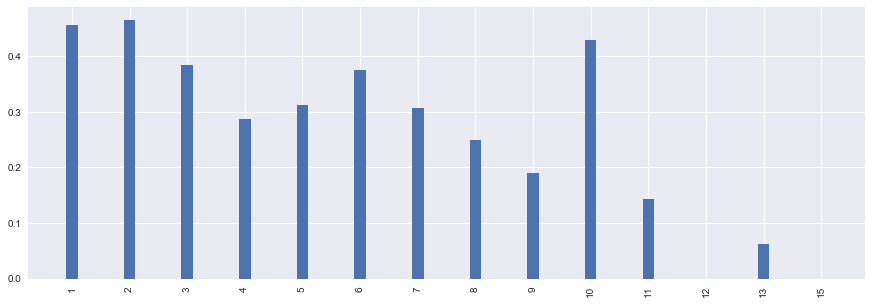

In [10]:
## Shows percentage of upsets by seed difference

############################################################
# add labels and stuff
############################################################
upset_bar_chart(no_play_ins, 'abs_seed_diff')

In [11]:
## Create a matchup dataframe on the team level-underdog where all teams

#################################################################################################
# this is repetitive and needs to be cleaned up
#################################################################################################

under_dog_df = team_game_df[team_game_df['seed'] != team_game_df['opponent_seed']].copy()
under_dog_df['underdog'] = [1 if seed_id[len(seed_id)-3:] == 'dog' else 0 for seed_id in under_dog_df['seed_id']]
under_dog_df = under_dog_df[under_dog_df['underdog'] == 1].copy()
under_dog_df['seed_diff'] = under_dog_df['opponent_seed'] - under_dog_df['seed']
under_dog_df['abs_seed_diff'] = abs(under_dog_df['seed_diff'])
under_dog_df['matchup'] = [seed_id if len(seed_id)<6 else seed_id[:len(seed_id)-4] for seed_id in under_dog_df['seed_id']]
best_fit = np.polyfit(under_dog_df['abs_seed_diff'], under_dog_df['win'], deg=1)
under_dog_df['best_fit'] = best_fit[0] * under_dog_df['abs_seed_diff'] + best_fit[1]

In [12]:
## create upsets_df

#################################################################################################
# this is repetitive and needs to be cleaned up
#################################################################################################

winner_df = team_game_df[team_game_df['win'] == 1]
winner_df = winner_df[winner_df['seed'] != winner_df['opponent_seed']]
winner_df['seed_diff'] = winner_df['opponent_seed'] - winner_df['seed']
winner_df['upset'] = [1 if seed_id[len(seed_id)-3:] == 'dog' else 0 for seed_id in winner_df['seed_id']]
winner_df['matchup'] = [seed_id if len(seed_id)<6 else seed_id[:len(seed_id)-4] for seed_id in winner_df['seed_id']]
winner_df['abs_seed_diff'] = abs(winner_df['seed_diff'])
upsets_groupby = winner_df[['win', 'upset', 'abs_seed_diff', 'matchup']].groupby(['abs_seed_diff', 'matchup'])
upsets_df = upsets_groupby.agg('sum')
upsets_df.columns = ['total_games', 'num_upsets']
upsets_df.reset_index(inplace=True)
upsets_df['upset_perc'] = upsets_df['num_upsets'] / upsets_df['total_games']
upsets_df['best_fit'] = best_fit[0] * upsets_df['abs_seed_diff'] + best_fit[1]
first_year = 1985
last_year = 2016
total_years = last_year - first_year
upsets_df['games_per_year'] = upsets_df['total_games'] / total_years

In [13]:
##############################################################################################################
# add bubble outlines
##############################################################################################################

def plot_all_matchups_best_fit(upsets_df, under_dog_df):
    plt.figure(figsize=(12,6))
    matchup_list = list(set(upsets_df['matchup']))
    for i in range(len(matchup_list)):
        matchup = matchup_list[i]
        matchup_df = upsets_df[upsets_df['matchup'] == matchup]
        plt.scatter(matchup_df['abs_seed_diff'], matchup_df['upset_perc'],
                    s=5*matchup_df['total_games'], c='#778899', alpha=0.5)  #484848
    plt.plot(under_dog_df['abs_seed_diff'], under_dog_df['best_fit'],
         linewidth = .3, color = 'black')  #B20000
    tick_loc = range(1,16)
    plt.xticks(tick_loc)
    plt.title('Percentage of Upset by Matchup')
    plt.xlabel('Match Up Seed Difference')
    plt.ylabel('Percentage of Upsets')

In [14]:
def plot_subset_matchups(subset_df, bottom_top_flag, num_matchups, color, marker):
    subset_df['adjusted_upset_perc'] = subset_df['upset_perc'] - subset_df['best_fit']
    subset_df.sort_values('adjusted_upset_perc', ascending=False, inplace=True)
    if bottom_top_flag == 'top':
        plot_df = subset_df.head(num_matchups)
        plot_df = plot_df[plot_df['adjusted_upset_perc'] > 0]
        if len(plot_df) == 0:
            print(f'No matchup(s) fit the stated criteria')
        elif len(plot_df) < num_matchups:
            print(f'Only {len(plot_df)} matchup(s) fit the stated criteria')
    elif bottom_top_flag == 'bottom':
        plot_df = subset_df.bottom(num_matchups)
        plot_df = plot_df[plot_df['adjusted_upset_perc'] < 0]
        if len(plot_df) == 0:
            print(f'No matchup(s) fit the stated criteria')
        elif len(plot_df) < num_matchups:
            print(f'Only {len(plot_df)} matchup(s) fit the stated criteria')
    matchup_list = list(set(plot_df['matchup']))
    for i in range(len(matchup_list)):
        matchup = matchup_list[i]
        matchup_df = plot_df[plot_df['matchup'] == matchup]
        plt.scatter(plot_df['abs_seed_diff'], plot_df['upset_perc'],
                    s=5*plot_df['total_games'], c=color,
                    marker = marker)

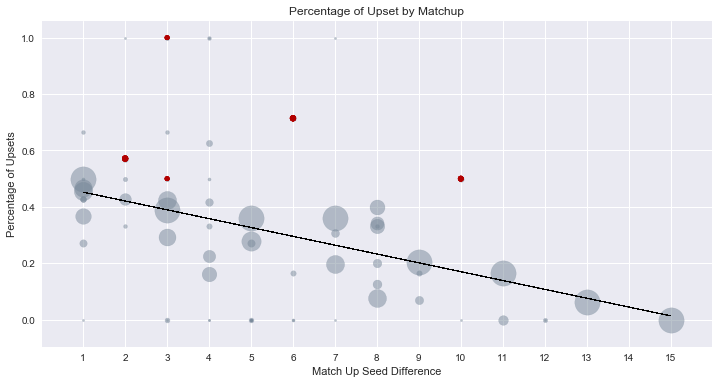

In [15]:
low_freq_df = upsets_df[(upsets_df['total_games'] > 3) & (upsets_df['games_per_year'] < .25)].copy()
plot_all_matchups_best_fit(upsets_df, under_dog_df)
plot_subset_matchups(low_freq_df, 'top', 5, '#B20000', 'o')
plt.show()

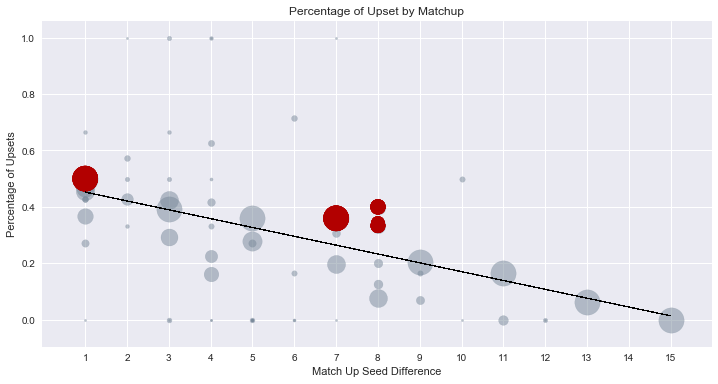

In [16]:
yearly_df = upsets_df[upsets_df['games_per_year'] >= 1].copy()
plot_all_matchups_best_fit(upsets_df, under_dog_df)
plot_subset_matchups(yearly_df, 'top', 5, '#B20000', 'o')
plt.show()

In [17]:
#Group by team to get all games played by each school in the NCAA tournament
grouped_by_team = no_play_ins.groupby(by="team")

#calculate stats for each team and find "best" in each category
columns = ["Team",
           "Tournament Appearances",
           "Games Played",
           "Games Won",
           "Win Percentage",
           "Total Point Margin",
           "Average Point Margin",
           "Average Number of Wins",
           "Expected Wins Using Historical Performance",
           "Expected Games Using Historical Performance",
           "Expected Win % Using Historical Performance",
           "Win % - Expected Win % Historical"
          ]
team_performance_summary = pd.DataFrame(columns=columns)
team_count = 0
for team,group in grouped_by_team:
    tournament_appearances = group['year'].nunique()
    games_played = len(group.index)
    games_won = group["win"].sum()
    win_percentage = games_won/games_played
    total_point_margin = (group["score"]-group["opponent_score"]).sum()
    average_point_margin = total_point_margin/games_played
    average_num_wins = games_won/tournament_appearances
    
    #find the seed of team for each tournament appearance
    seeds = [int(group.loc[group.index[0],'seed'])]
    if len(group.index) > 1:
        previous_year = group.loc[group.index[0],'year']
        for index,row in group.iterrows():
            if row["year"] != previous_year:
                seeds.append(int(row['seed']))
            previous_year = row["year"]
    
    #find the number of expected wins and the expected number of games won/played for each tournament based on historical averages
    expected_wins_historical = 0
    expected_games_historical = 0
    for seed in seeds:
        expected_wins_historical += float(seed_summaries.loc[int(seed),'Average Wins'])
        expected_games_historical += float(seed_summaries.loc[int(seed),'Average Wins']) + 1
    expected_win_percentage_historical = expected_wins_historical/expected_games_historical 
    win_percentage_difference_historical = win_percentage - expected_win_percentage_historical
         
    row_to_add = {'Team':team,
                  'Tournament Appearances':tournament_appearances,
                  'Games Played':games_played,
                  'Games Won':games_won,
                  'Win Percentage':win_percentage,
                  'Total Point Margin':total_point_margin,
                  'Average Point Margin':average_point_margin,
                  'Average Number of Wins':average_num_wins,
                  "Expected Wins Using Historical Performance":expected_wins_historical,
                  "Expected Games Using Historical Performance":expected_games_historical,
                  "Expected Win % Using Historical Performance":expected_win_percentage_historical,
                  "Win % - Expected Win % Historical":win_percentage_difference_historical
                 }
    team_performance_summary.loc[team_count,:] = row_to_add
    team_count +=1
team_performance_summary.head()

,Team,Tournament Appearances,Games Played,Games Won,Win Percentage,Total Point Margin,Average Point Margin,Average Number of Wins,Expected Wins Using Historical Performance,Expected Games Using Historical Performance,Expected Win % Using Historical Performance,Win % - Expected Win % Historical
0,Air Force,2,2,0,0,-20,-10,0,0.828125,2.82812,0.292818,-0.292818
1,Akron,4,4,0,0,-78,-19.5,0,0.914062,4.91406,0.18601,-0.18601
2,Alabama,15,33,18,0.545455,34,1.0303,1.2,16.8203,31.8203,0.528603,0.0168516
3,Alabama State,2,2,0,0,-69,-34.5,0,0,2,0,0
4,Albany,5,5,0,0,-73,-14.6,0,0.5,5.5,0.0909091,-0.0909091


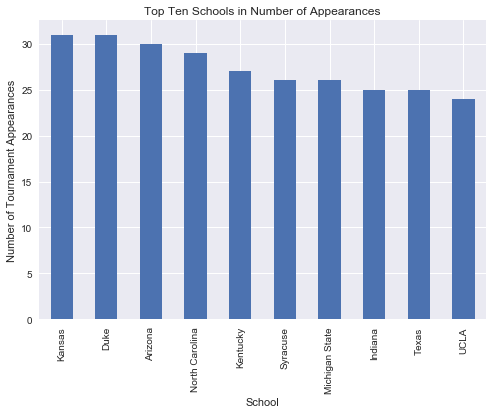

In [18]:
#Most Tournament Appearances
most_appearances = team_performance_summary.sort_values(by="Tournament Appearances",ascending=False).iloc[:10,:]

x = np.arange(len(most_appearances.index))
most_appearances["Tournament Appearances"].plot(x=x,kind='Bar',grid='on')
plt.xticks(x,list(most_appearances['Team']))
plt.xlabel('School')
plt.ylabel("Number of Tournament Appearances")
plt.title("Top Ten Schools in Number of Appearances")
plt.show()

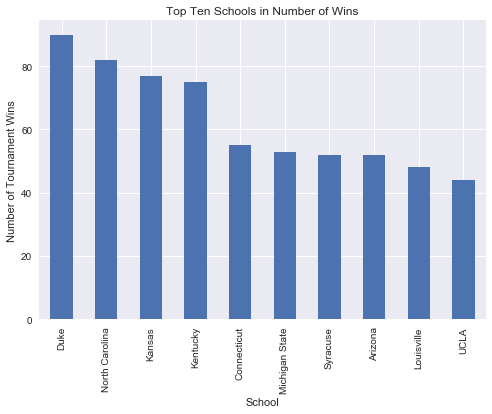

In [19]:
#Most Games Won
most_wins = team_performance_summary.sort_values(by="Games Won",ascending=False).iloc[:10,:]

x = np.arange(len(most_wins.index))
most_wins["Games Won"].plot(x=x,kind='Bar',grid='on')
plt.xticks(x,list(most_wins['Team']))
plt.xlabel('School')
plt.ylabel("Number of Tournament Wins")
plt.title("Top Ten Schools in Number of Wins")
plt.show()

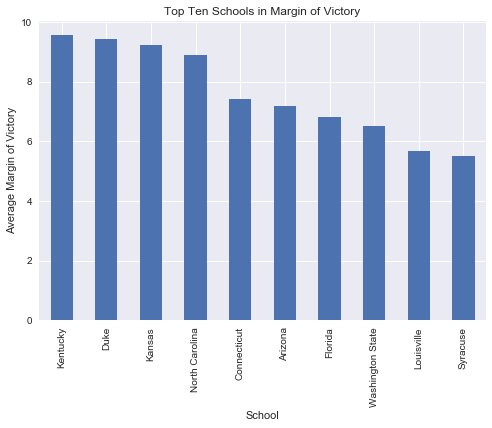

In [20]:
#Best Average Margin of Victory
best_average_point_margin = team_performance_summary.sort_values(by="Average Point Margin",ascending=False).iloc[:10,:]

x = np.arange(len(best_average_point_margin.index))
best_average_point_margin["Average Point Margin"].plot(x=x,kind='Bar',grid='on')
plt.xticks(x,list(best_average_point_margin['Team']))
plt.xlabel('School')
plt.ylabel("Average Margin of Victory")
plt.title("Top Ten Schools in Margin of Victory")
plt.show()

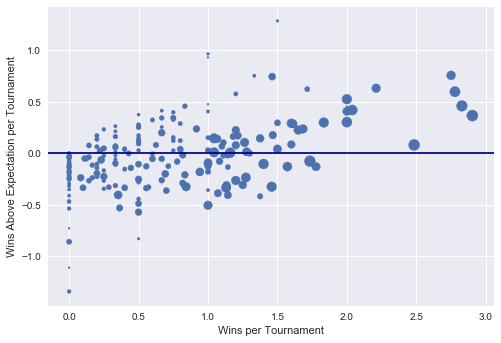

In [21]:
win_difference_average = (team_performance_summary.loc[:,'Games Won'] - team_performance_summary.loc[:,'Expected Wins Using Historical Performance'])/team_performance_summary.loc[:,'Tournament Appearances']
plt.scatter(team_performance_summary.loc[:,'Average Number of Wins'],win_difference_average,s=4*team_performance_summary.loc[:,'Tournament Appearances'].astype('float'))
plt.xlabel("Wins per Tournament")
plt.ylabel("Wins Above Expectation per Tournament")
plt.axhline(y=0,color='darkblue')
plt.show()

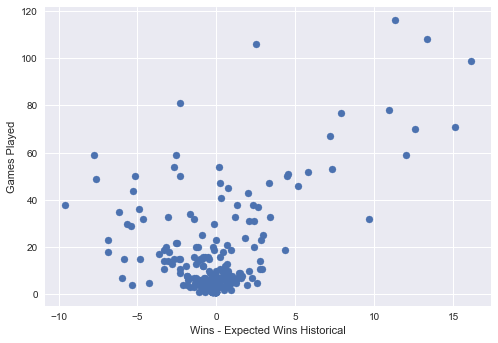

In [22]:
win_difference = team_performance_summary.loc[:,'Games Won'] - team_performance_summary.loc[:,'Expected Wins Using Historical Performance']
plt.scatter(win_difference,team_performance_summary.loc[:,'Games Played'])
plt.xlabel("Wins - Expected Wins Historical")
plt.ylabel("Games Played")
plt.show()